# Credit Card Fraud: Ensemble Methods

We pick up here where the previous project ended. The goal is to train an ensemble method on the credit card dataset from the previous project. We'll import the preprocessed test dataset, identify candidate predictors, and train a random forest classifier. The objective is to predict whether or not a given credit card transaction is fraudulent. 

## Import Training Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [20]:
train_data = pd.read_csv("C:\\Users\\mbadi\\Desktop\\Kaggle_Projects\\cc_train.csv")

In [100]:
X_train = train_data.drop("Class", axis=1, inplace=False)
y_train = train_data["Class"].to_numpy().reshape(train_data.shape[0])

We'll need to verify that the train data is balanced with respect to the target variable....

In [31]:
train_data["Class"].value_counts()/len(train_data["Class"])

1    0.5
0    0.5
Name: Class, dtype: float64

...and so it is. Had we trained a model on the original, unbalanced dataset (skewed 99/1), said model would have attributed to underlying cause what is instead attributable to sampling, giving us inaccurate predictions. 

## Variable Selection

Let's look at a heatmap of the correlation matrix of our training data to get an idea of which predictors  most influence the target variable, "Class". Below is a simple function that produces a correlation heatmap given a dataset. 

In [22]:
def corr_heatmap(X):
    cor = X.corr()
    return(sns.heatmap(cor))

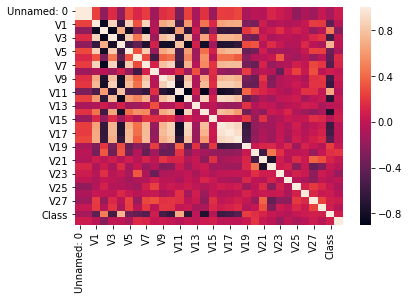

In [26]:
corr_heatmap(train_data)

We observe that "Class" positively correlates most with variables V4 and V11; "Class" negatively correlates most with V12, V14, and V17. Hence, we infer that a good model will highlight a subset of these predictors. Given the small sample size of our data (no more than 800), we'd do well to not consider more than two or three predictors, lest we fall victim to the "Curse of Dimensionality". 

## Fine Tuning a Random Forest Classifier

We turn to Scikit Learn to import a Random Forest Classifier and to import the tools with which we'll fine tune and evaluate said classifier. 

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [91]:
rf = RandomForestClassifier()

The variable "param_grid" below is a dictionary that defines the hyperparameter space over which we will fine-tune the random forest classifier. Note that we consider both bootstrap=True and bootstrap=False. The next four cells of code train and fine-tune the model on the data. Note that we wrote Grid Search to consider no more than three predictors at a time, given our small sample size. 

In [122]:
param_grid = [
    {'n_estimators': [10,50,100,120], 'max_features':[1,2,3]},
    {'bootstrap':[False], 'n_estimators': [10,50,100,120], 'max_features': [1,2,3]},
]

In [126]:
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [129]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 100}

In [103]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We take the model identified by Grid Search as the best and measure its cross-validated accuracy on the training data. 

In [130]:
clf = grid_search.best_estimator_
print(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))

0.9467056150600455


The fine-tuned random forest classifier achieves almost 95% accuracy, not bad. Let's see which variables were deemed by Grid Search to be the most influential on the target variable. 

In [136]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, X_train.columns), reverse=True)

[(0.12962802580505692, 'V14'),
 (0.1106044903658258, 'V12'),
 (0.08769528829527451, 'V10'),
 (0.07895094008540242, 'V17'),
 (0.07706228357098799, 'V11'),
 (0.06706601786337422, 'V4'),
 (0.061566673061124504, 'V16'),
 (0.036840910519664205, 'V7'),
 (0.034718629566253524, 'V3'),
 (0.03468012563015081, 'V2'),
 (0.03336798366522066, 'V6'),
 (0.030053924017531403, 'V9'),
 (0.020904482192231743, 'V5'),
 (0.020351156526227, 'V21'),
 (0.019039324542199924, 'V18'),
 (0.015875075929580873, 'V27'),
 (0.015543770121637915, 'V1'),
 (0.013732252554754009, 'V8'),
 (0.012871218900092168, 'V19'),
 (0.012547443167300266, 'V20'),
 (0.011789911636549931, 'Amount_Norm'),
 (0.011047593913143812, 'V28'),
 (0.008625010513438412, 'V22'),
 (0.008365579840005365, 'V26'),
 (0.008140460059648266, 'V15'),
 (0.008040079576982937, 'V25'),
 (0.0070452886892737095, 'V13'),
 (0.00624697275690576, 'V23'),
 (0.0062306779838416804, 'Unnamed: 0.1'),
 (0.005818143187695205, 'V24'),
 (0.005550265462623918, 'Unnamed: 0')]

Looks like V14, V12, and V10 are the top three most influential predictors. All that's left is to import the test data and test our trained model. 

In [137]:
test_data = pd.read_csv("C:\\Users\\mbadi\\Desktop\\Kaggle_Projects\\cc_test.csv")

In [138]:
X_test = test_data.drop("Class", axis=1, inplace=False)
y_test = test_data["Class"].to_numpy().reshape(test_data.shape[0])

In [139]:
from sklearn.metrics import accuracy_score

In [140]:
accuracy_score(y_test, clf.predict(X_test))

0.9438775510204082

## Conclusion

The final model achieves 94% accuracy when predicting instances in the test dataset. It's worth noting that Grid Search preferred three predictors, even though our sample size is small. If we refer back to the heatmap, we'll observe a high degree of covariance among the predictors. This means that several predictors either measure very similar phenomenon, or that several predictors can be traced to a common cause. This lets us get away with using three predictors to achieve 94% accuracy on such a small data sample. 

## Works Cited

Thanks again to the Scikit Learn team: https://scikit-learn.org/stable/

As well as to kaggle for the dataset:  https://www.kaggle.com/mlg-ulb/creditcardfraud